<a href="https://colab.research.google.com/github/etoileboots/tbilisi_biking/blob/main/MASK2FORMER_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.7 MB/s eta 0:00:00


In [ ]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/9.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/432M [00:00<?, ?B/s]

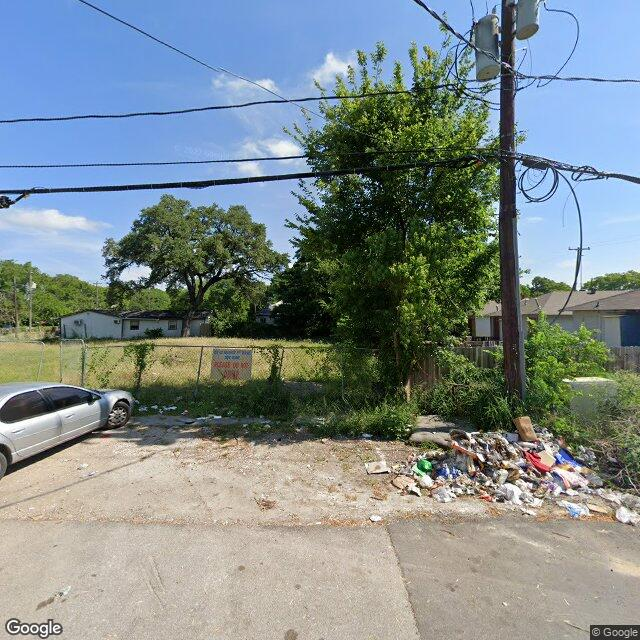

In [ ]:
from PIL import Image
import requests

FORCE_CUDA = 1

url = "/content/drive/MyDrive/capstone/data/min_onroads_gsv_directory/block_482012108002_point_9_heading_0.jpg"
image = Image.open(url)
image

In [ ]:
inputs = processor(images=image, return_tensors="pt")
for k,v in inputs.items():
  print(k,v.shape)


pixel_values torch.Size([1, 3, 384, 384])
pixel_mask torch.Size([1, 384, 384])


In [ ]:
import torch

with torch.no_grad():
  outputs = model(**inputs)


In [ ]:
# you can pass them to processor for postprocessing
results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
print(results.keys())


`label_ids_to_fuse` unset. No instance will be fused.


dict_keys(['segmentation', 'segments_info'])


In [ ]:
for segment in results['segments_info']:
  print(segment)


{'id': 1, 'label_id': 119, 'was_fused': False, 'score': 0.999735}
{'id': 2, 'label_id': 100, 'was_fused': False, 'score': 0.943613}
{'id': 3, 'label_id': 116, 'was_fused': False, 'score': 0.997797}
{'id': 4, 'label_id': 130, 'was_fused': False, 'score': 0.868075}
{'id': 5, 'label_id': 91, 'was_fused': False, 'score': 0.953705}
{'id': 6, 'label_id': 117, 'was_fused': False, 'score': 0.970892}
{'id': 7, 'label_id': 9, 'was_fused': False, 'score': 0.536024}
{'id': 8, 'label_id': 2, 'was_fused': False, 'score': 0.999178}


In [ ]:
segment_to_label = {segment['id']: segment['label_id'] for segment in results["segments_info"]}
print(segment_to_label)


{1: 119, 2: 100, 3: 116, 4: 130, 5: 91, 6: 117, 7: 9, 8: 2}


Visualizing mask for: tree-merged


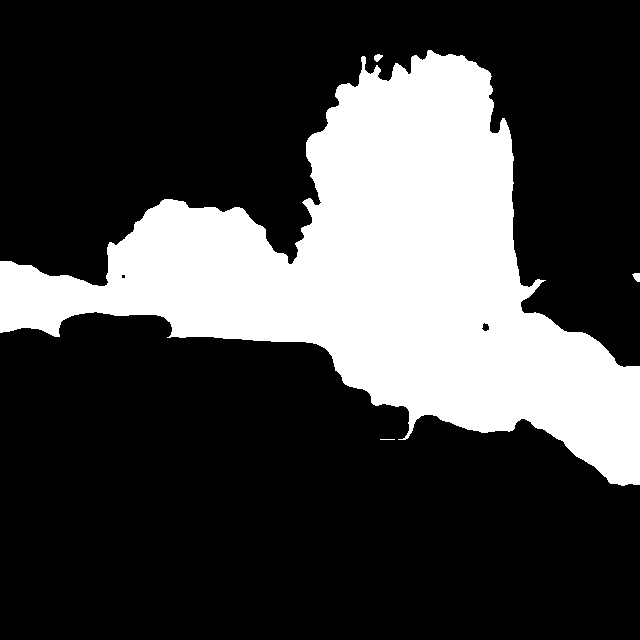

In [ ]:
import numpy as np

def get_mask(segment_id):
  print("Visualizing mask for:", model.config.id2label[segment_to_label[segment_id]])

  mask = (results['segmentation'].numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)

  return visual_mask

# note: segment with id == 0 means "background",
# so we visualize segment with id == 1 here
get_mask(segment_id=3)


<ipython-input-42-0f4a5a65b784>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


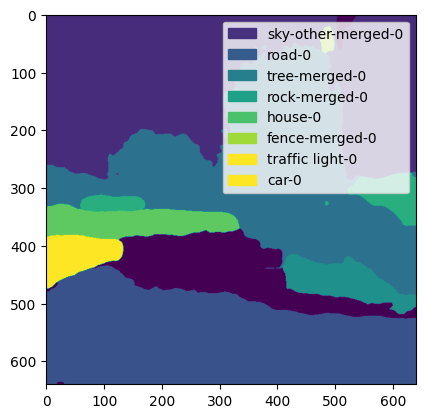

In [ ]:
# code taken from: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Mask2Former/Inference_with_Mask2Former.ipynb
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    ax.legend(handles=handles)

draw_panoptic_segmentation(**results)

In [ ]:
import os
from PIL import Image
import torch
import numpy as np
import pandas as pd
from collections import defaultdict
from transformers import Mask2FormerImageProcessor, Mask2FormerForImageSegmentation

# Load Mask2Former Model and Processor
model = Mask2FormerForImageSegmentation.from_pretrained("facebook/mask2former-swin-large-cityscapes-panoptic")
processor = Mask2FormerImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-panoptic")

def process_images(image_folder):
    """
    Processes images, segments them, and aggregates features at the block group level.
    """
    # Dictionary to hold aggregated statistics for each block group
    block_group_data = defaultdict(lambda: defaultdict(int))
    block_group_pixel_count = defaultdict(int)

    for image_name in os.listdir(image_folder):
        if not image_name.endswith('.jpg'):
            continue

        # Extract block group ID
        block_id = image_name.split('_')[1]
        image_path = os.path.join(image_folder, image_name)
        image = Image.open(image_path).convert("RGB")

        # Process and perform segmentation
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)

        # Post-process segmentation to get segmentation map and segment information
        results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
        segments_info = results['segments_info']
        segmentation = results['segmentation'].numpy()

        # Map each segment ID to its label ID
        segment_to_label = {segment['id']: segment['label_id'] for segment in segments_info}

        # Aggregate pixels by label ID for the block group
        for segment_id, label_id in segment_to_label.items():
            label = model.config.id2label[label_id]
            pixel_count = np.sum(segmentation == segment_id)
            block_group_data[block_id][label] += pixel_count
            block_group_pixel_count[block_id] += pixel_count

    # Normalize to calculate densities for each block group
    block_group_summary = []
    for block_id, feature_counts in block_group_data.items():
        total_pixels = block_group_pixel_count[block_id]
        summary = {'block_group': block_id}
        for feature, count in feature_counts.items():
            summary[f'{feature}_density'] = count / total_pixels
        block_group_summary.append(summary)

    return pd.DataFrame(block_group_summary)

# Define image folder path and process
image_folder =  "/content/drive/MyDrive/capstone/data/min_onroads_gsv_directory"
df = process_images(image_folder)

# Save to Excel for analysis
df.to_excel("block_group_segmentation_features.xlsx", index=False)
